# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
from stock_prices_predictions.get_data import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
#import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mean_absolute_percentage_error
import joblib
from tensorflow.keras.models import load_model

In [2]:
list_of_10_stocks = ['T', 'INTC', 'ADBE', 'JPM', 'PG', 'NVDA', 'AAPL', 'AMZN', 'UNH', 'MA']
#list_of_10_stocks = ['T', 'INTC']

# Loads model and transformer

In [3]:
cwd = os.getcwd()
simp_path4 = 'raw_data/df.csv'
abs_path4 = os.path.abspath(os.path.join(cwd,'..',simp_path4))

In [4]:
dict_of_scaler = {}
dict_of_model = {}

for stock in list_of_10_stocks:
    dict_of_scaler[stock] = joblib.load(f'{stock}_scaler.joblib')
    dict_of_model[stock] = load_model(f'{stock}_model.h5')

In [5]:
#dict_of_model.keys()

# Load dataframe

In [6]:
df = get_portfolio_data()

In [7]:
#df.dtypes

In [8]:
#df.head(5)

# Create classes

In [9]:
class Stock:
    def __init__(self, name, initial_price, final_price, dollars):
        self.name = name
        self.initial_price = initial_price
        self.final_price = final_price
        
        self.current_price = initial_price

        self.amount_owned = dollars
        self.num_shares = dollars/initial_price
        self.prediction_higher = True
        self.num_shares_hold = dollars/initial_price
        
        self.prediction = 0.0
        self.prices = 0.0
    
    def prices(self,number):
        self.prices = number
         

# User input

In [10]:
initial_date = '2015-02-02'
final_date = '2016-12-30'
initial_amount = 10000 #amount invested
in_hand = 0 #he has in wallet

# Instatiate classes

In [11]:
list_stocks = {}
for i in list_of_10_stocks:
    qty = len(list_of_10_stocks)
    price = df[(df["date"]==initial_date) & (df["ticker"]==i)]
    final_price = df[(df["date"]==final_date) & (df["ticker"]==i)]
    list_stocks[i] = Stock(i, price['adj_close'], final_price['adj_close'], initial_amount/qty)

In [12]:
list_stocks

{'T': <__main__.Stock at 0x7fb6986930a0>,
 'INTC': <__main__.Stock at 0x7fb698693340>,
 'ADBE': <__main__.Stock at 0x7fb69877a130>,
 'JPM': <__main__.Stock at 0x7fb69877ac10>,
 'PG': <__main__.Stock at 0x7fb69877a4f0>,
 'NVDA': <__main__.Stock at 0x7fb69877a8e0>,
 'AAPL': <__main__.Stock at 0x7fb6987e0730>,
 'AMZN': <__main__.Stock at 0x7fb6987e02b0>,
 'UNH': <__main__.Stock at 0x7fb6987e00d0>,
 'MA': <__main__.Stock at 0x7fb69879b580>}

# Create predictions

In [13]:
for s in list_stocks:
    df_T2 = df[df['ticker']== s]
    df_T2.reset_index(inplace=True)
    ind = df_T2.index[df_T2['date'] == initial_date].tolist()
    ind2 = df_T2.index[df_T2['date'] == final_date].tolist()
    df_T2 = df_T2[ind[0]-18:ind2[0]+1]
    df_T2 = df_T2.adj_close
    df_T2 = pd.DataFrame(df_T2)
    
    scaler = dict_of_scaler[s]
    X_test_T = scaler.transform(df_T2)
    
    model = dict_of_model[s]
    X_test_T2 = create_sequences_scaled(pd.DataFrame(X_test_T))
    prediction = model.predict(X_test_T2)

    prediction_back = scaler.inverse_transform(prediction.reshape(-1, 1))
    
    list_stocks[s].prediction = prediction_back
    
    df_T2 = df[df['ticker']== s]
    df_T2.reset_index(inplace=True)
    ind = df_T2.index[df_T2['date'] == initial_date].tolist()
    ind2 = df_T2.index[df_T2['date'] == final_date].tolist()
    df_T2 = df_T2[ind[0]:ind2[0]+1]
    list_stocks[s].prices = df_T2

# Return of buy and hold

In [14]:
buyandhold = 0.0
for i in list_stocks:
    #print(list_stocks[i].amount_owned / list_stocks[i].initial_price *float(list_stocks[i].final_price))
    buyandhold+=float(list_stocks[i].amount_owned / list_stocks[i].initial_price *float(list_stocks[i].final_price))

In [15]:
buyandhold

18122.71670571803

# Loop through days using models

In [16]:
df_ = df[df['ticker']== 'T']
df_.reset_index(inplace=True)
ind = df_.index[df_['date'] == initial_date].tolist()
ind2 = df_.index[df_['date'] == final_date].tolist()
df_ = df_[ind[0]:ind2[0]+1]

In [17]:
buyandholdgraph = [] #added today
aitradergraph = [] #added today

#loops through days
for i in range(len(df_)-1):
    print(f"-----------------")
    print(f"loop number: {i}")

    #for each day it checks the prediction and appends buy list
    buy_list = []
    
    for s in list_stocks:
        if float(list_stocks[s].prediction[i]) >= float(list_stocks[s].current_price):
            #list_stocks[s].prediction_higher = True
            buy_list.append(s)
        #else: 
            #list_stocks[s].prediction_higher = False

    #sells and puts all the money on wallet
    for s in list_stocks:
        in_hand += float(list_stocks[s].num_shares * list_stocks[s].current_price)
        #list_stocks[s].amount_owned = 0
        list_stocks[s].num_shares = 0
    
    print(f"buy list: {buy_list}")

    #buys
    if len(buy_list) > 0:
        for l in buy_list:
            amount_to_buy = float(in_hand / len(buy_list))

            list_stocks[l].num_shares =  amount_to_buy / float(list_stocks[l].current_price)

        in_hand = 0

    
    owned=0
    for s in list_stocks:
        owned += float(list_stocks[s].num_shares * list_stocks[s].current_price)  
    
    #create the data for the graphs
    buyandhold_ = 0
    aitrader_= 0
    
    for s in list_stocks:
        buyandhold_ += float(list_stocks[s].num_shares_hold) * float(list_stocks[s].current_price)
        aitrader_ += float(list_stocks[s].num_shares) * float(list_stocks[s].current_price)
    
    aitrader_+=in_hand
    buyandholdgraph.append(buyandhold_)
    aitradergraph.append(aitrader_)
    
    #update current price
    for s in list_stocks:
        list_stocks[s].current_price = list_stocks[s].prices.adj_close.iloc[i]
    

        
    #print(f"amount in hand after loop: {in_hand}")

-----------------
loop number: 0
buy list: ['INTC']
-----------------
loop number: 1
buy list: ['INTC', 'NVDA']
-----------------
loop number: 2
buy list: ['INTC', 'NVDA']
-----------------
loop number: 3
buy list: ['INTC', 'NVDA']
-----------------
loop number: 4
buy list: ['INTC']
-----------------
loop number: 5
buy list: ['INTC', 'NVDA']
-----------------
loop number: 6
buy list: ['INTC', 'NVDA']
-----------------
loop number: 7
buy list: ['INTC']
-----------------
loop number: 8
buy list: ['INTC', 'NVDA']
-----------------
loop number: 9
buy list: ['INTC', 'NVDA']
-----------------
loop number: 10
buy list: ['INTC', 'NVDA']
-----------------
loop number: 11
buy list: ['INTC']
-----------------
loop number: 12
buy list: ['INTC', 'NVDA']
-----------------
loop number: 13
buy list: ['INTC', 'NVDA']
-----------------
loop number: 14
buy list: ['INTC']
-----------------
loop number: 15
buy list: ['INTC', 'NVDA']
-----------------
loop number: 16
buy list: []
-----------------
loop numb

buy list: ['INTC', 'NVDA']
-----------------
loop number: 260
buy list: ['INTC', 'JPM', 'NVDA']
-----------------
loop number: 261
buy list: ['INTC', 'NVDA']
-----------------
loop number: 262
buy list: ['INTC', 'NVDA']
-----------------
loop number: 263
buy list: ['INTC', 'NVDA']
-----------------
loop number: 264
buy list: ['NVDA']
-----------------
loop number: 265
buy list: ['INTC', 'NVDA']
-----------------
loop number: 266
buy list: []
-----------------
loop number: 267
buy list: ['INTC', 'NVDA']
-----------------
loop number: 268
buy list: ['INTC', 'NVDA']
-----------------
loop number: 269
buy list: ['INTC']
-----------------
loop number: 270
buy list: []
-----------------
loop number: 271
buy list: ['INTC', 'NVDA']
-----------------
loop number: 272
buy list: ['INTC', 'NVDA']
-----------------
loop number: 273
buy list: ['INTC']
-----------------
loop number: 274
buy list: ['INTC']
-----------------
loop number: 275
buy list: ['INTC']
-----------------
loop number: 276
buy lis

# Checks final amounts

In [18]:
in_hand

0

In [19]:
final_amount = in_hand
for s in list_stocks:
    final_amount += float(list_stocks[s].num_shares * list_stocks[s].current_price)
    

In [20]:
final_amount

72981.73265357115

In [21]:
print(f"Buy and hold strategy made {buyandhold - initial_amount} ({(buyandhold - initial_amount)/initial_amount * 100}%)")
print(f"Our AI trader made {final_amount - initial_amount} ({(final_amount - initial_amount)/initial_amount * 100}%)")

Buy and hold strategy made 8122.71670571803 (81.22716705718031%)
Our AI trader made 62981.73265357115 (629.8173265357115%)


# Graph results

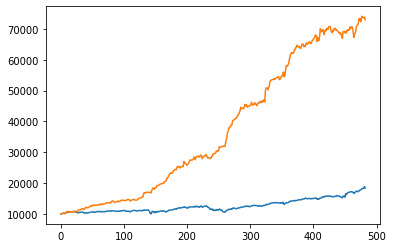

In [22]:
plt.plot(buyandholdgraph)
plt.plot(aitradergraph)

In [23]:
buyandholdgraph

[10000.0,
 10000.0,
 10105.871830834843,
 10128.196707826974,
 10248.742920274217,
 10195.490819962266,
 10157.064977829248,
 10281.935826773017,
 10302.482446072447,
 10506.499414945129,
 10552.384209222466,
 10576.819228402692,
 10551.771439828128,
 10559.555582639712,
 10656.185234503724,
 10671.541212712893,
 10712.958178581537,
 10699.44812890597,
 10710.824039645027,
 10646.351702664519,
 10772.810451673096,
 10707.480261158833,
 10688.636442056191,
 10732.12385998292,
 10564.630000128342,
 10594.327969773754,
 10396.488927224349,
 10363.300288650556,
 10458.07244931144,
 10413.90604596469,
 10540.55738531752,
 10545.21107327307,
 10583.42445035486,
 10570.221386446985,
 10625.308450366736,
 10555.802837688092,
 10471.579306135285,
 10226.085246014294,
 10221.94465345793,
 10313.838220640413,
 10413.634315307869,
 10295.531723667433,
 10298.97964288737,
 10346.0730433573,
 10441.357816451053,
 10430.806780537067,
 10484.339042102009,
 10545.866684269273,
 10593.5162720175,
 10577

In [24]:
final_amount

72981.73265357115